<a href="https://colab.research.google.com/github/Harika11114141/Array-Data-Structures/blob/main/Bangalore_House_Price_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import files
uploaded = files.upload()


Saving bengaluru_house_prices.csv to bengaluru_house_prices.csv


In [15]:
import pandas as pd
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [16]:
# Check the shape of the dataset
df1.shape


(13320, 9)

In [17]:
# Display column names
df1.columns


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [18]:
# Display unique values in the 'area_type' column
df1['area_type'].unique()


array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [19]:
# Count occurrences of each unique value in 'area_type'
df1['area_type'].value_counts()


,count
area_type,
Super built-up Area,8790
Built-up Area,2418
Plot Area,2025
Carpet Area,87


In [20]:
#Remove columns that won’t be used in the model.
df2 = df1.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns')
df2.shape

(13320, 5)

In [21]:
#Drop rows with missing values.
df2.isnull().sum()  # Check for missing values
df3 = df2.dropna()  # Drop missing values
df3.isnull().sum()  # Verify no missing values remain
df3.shape


(13246, 5)

In [22]:
# Extract bhk (number of bedrooms) from the size column.
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

<ipython-input-22-076a2819a85a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [25]:
#Clean the total_sqft column by handling ranges and non-numeric values.
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df3[~df3['total_sqft'].apply(is_float)].head(10)

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]


In [26]:
#Add a new feature for price per square foot.
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000 / df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
#Clean and reduce the dimensions of location values.
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)

location_stats_less_than_10 = location_stats[location_stats <= 10]
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [28]:
#Remove outliers based on domain logic and statistical methods.
df6 = df5[~(df5.total_sqft / df5.bhk < 300)]

def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df7 = remove_pps_outliers(df6)

def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices,
                                             bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

df8 = remove_bhk_outliers(df7)


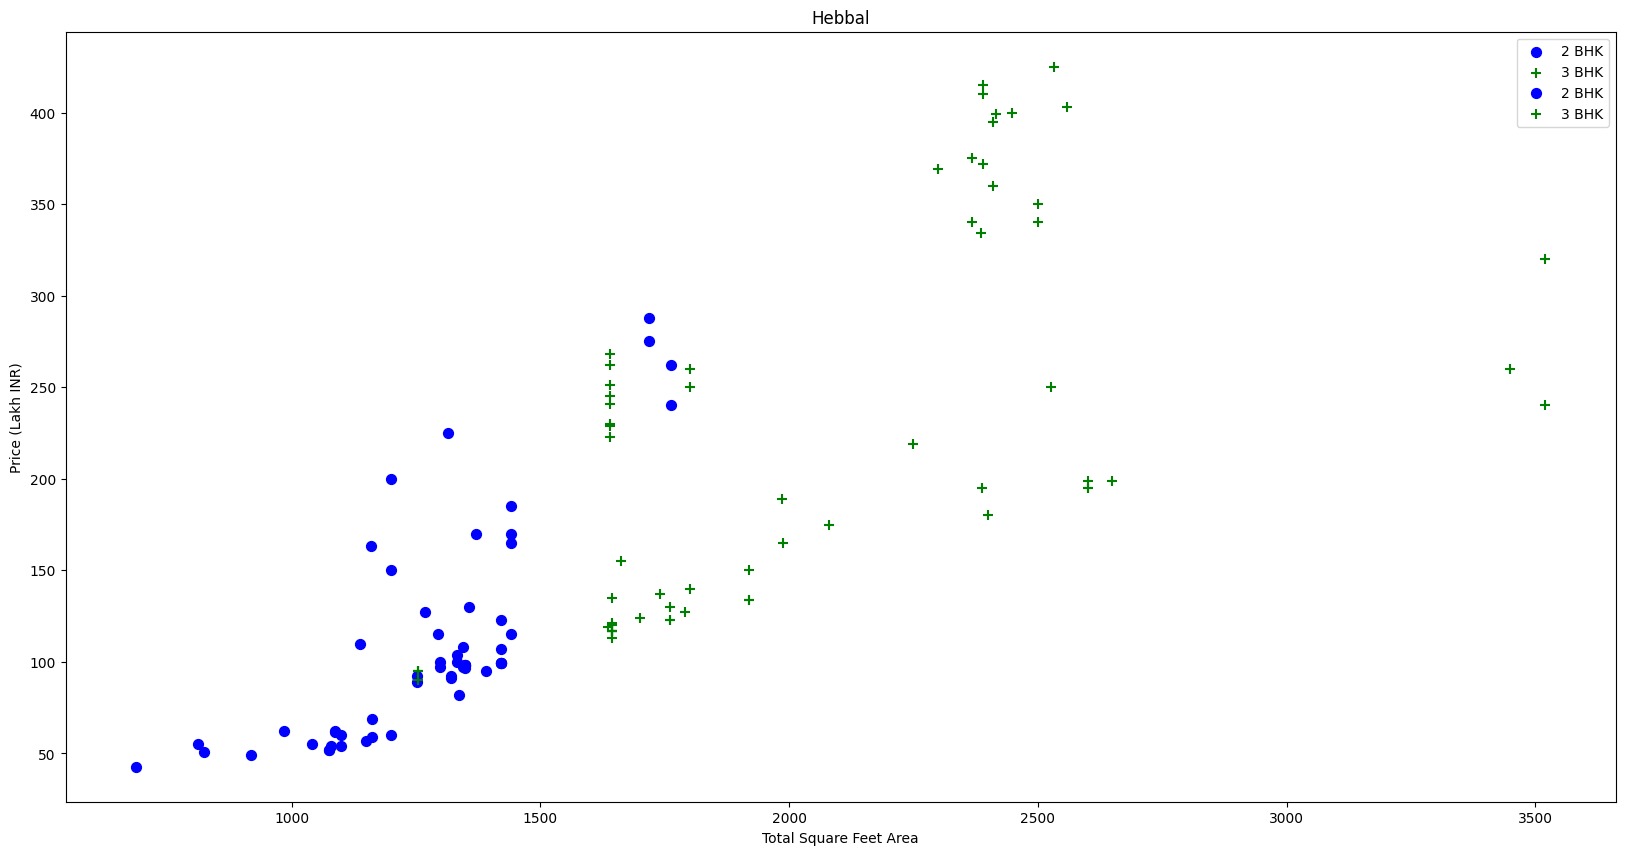

In [29]:
# Visualize patterns using scatter plots and histograms.
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh INR)")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df8, "Rajaji Nagar")
plot_scatter_chart(df8, "Hebbal")


In [30]:
#Use one-hot encoding for location data.
dummies = pd.get_dummies(df8.location)
df11 = pd.concat([df8, dummies.drop('other', axis='columns')], axis='columns')
df12 = df11.drop('location', axis='columns')

In [40]:
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                # 'normalize': [True, False]  # This line has been removed
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {'alpha': [1, 2], 'selection': ['random', 'cyclic']}
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {'criterion': ['mse', 'friedman_mse'], 'splitter': ['best', 'random']}
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algos.items():
        # Create a pipeline to include scaling before model fitting
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Feature normalization
            ('model', config['model'])
        ])

        gs = GridSearchCV(pipeline, config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({'model': algo_name, 'best_score': gs.best_score_, 'best_params': gs.best_params_})

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])

# Example usage (make sure to define X and y before calling this function)
# best_models_df = find_best_model_using_gridsearchcv(X, y)
# print(best_models_df)


In [42]:
#Define a function to predict property prices and export the model.
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns == location)[0][0]
    x = np